In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import feather
import warnings
from IPython.display import display
from folium.plugins import HeatMap
#import ipyleaflet
#from ipyleaflet import MarkerCluster, basemaps, CircleMarker
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
hv = pd.read_csv("hv_cleaned.csv", index_col = [0]) # index_col = [0] removes unnmaed index column
path = 'hv_cleaned.feather'
feather.write_dataframe(hv, path)
hv = feather.read_dataframe(path)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category
0,INV-24107200133,12/23/2019,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store
1,INV-24090200052,12/20/2019,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket
2,INV-24117700068,12/23/2019,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore
3,INV-24105000057,12/23/2019,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store
4,INV-24117300020,12/23/2019,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore


In [5]:
hv["Date"] =  pd.to_datetime(hv["Date"], format="%m/%d/%Y")

In [6]:
hv['Year'] = hv['Date'].dt.year
hv['Month'] = hv['Date'].dt.month

In [7]:
hv["Year"].value_counts()

2021    686488
2020    650365
2022    151029
2019     82644
2016       183
2018        94
2017         7
Name: Year, dtype: int64

In [8]:
hv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570810 entries, 0 to 1570809
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Invoice/Item Number    1570810 non-null  object        
 1   Date                   1570810 non-null  datetime64[ns]
 2   Store Number           1570810 non-null  int64         
 3   Store Name             1570810 non-null  object        
 4   Address                1570810 non-null  object        
 5   City                   1570810 non-null  object        
 6   Zip Code               1570810 non-null  int64         
 7   Store Location         1570810 non-null  object        
 8   County Number          1570810 non-null  int64         
 9   County                 1570810 non-null  object        
 10  Category               1570810 non-null  int64         
 11  Category Name          1570810 non-null  object        
 12  Vendor Number          15708

In [9]:
hv["Type"] = "Liqueur"
hv.loc[hv["Category Name"].str.contains('Gin'), "Type"] = 'Gin'
hv.loc[hv["Category Name"].str.contains('Whiskey'), "Type"] = 'Whiskey'
hv.loc[hv["Category Name"].str.contains('Whiskies'), "Type"] = 'Whiskey'
hv.loc[hv["Category Name"].str.contains('Rum'), "Type"] = 'Rum'
hv.loc[hv["Category Name"].str.contains('Vodka'), "Type"] = 'Vodka'
hv.loc[hv["Category Name"].str.contains('Tequila'), "Type"] = 'Tequila'
hv.loc[hv["Category Name"].str.contains('Mezcal'), "Type"] = 'Mezcal'
hv.loc[hv["Category Name"].str.contains('BRANDIES'), "Type"] = 'Brandy'
hv.loc[hv["Category Name"].str.contains('Brandies'), "Type"] = 'Brandy'
hv.loc[hv["Category Name"].str.contains('Scotch'), "Type"] = 'Scotch'
hv.loc[hv["Category Name"].str.contains('Cocktails'), "Type"] = 'Cocktail'
hv.loc[hv["Category Name"].str.contains('Schnapps'), "Type"] = 'Schnapps'
hv.loc[hv["Category Name"].str.contains('Liqueur'), "Type"] = 'Liqueur'
hv.loc[hv["Category Name"].str.contains('Specialty Packages'), "Type"] = 'Specialty Packages'
hv.loc[hv["Category Name"].str.contains('ANISETTE'), "Type"] = 'Anisette'
hv.loc[hv["Category Name"].str.contains('Brandy'), "Type"] = 'Brandy'
hv.loc[hv["Category Name"].str.contains('Bourbon'), "Type"] = 'Whiskey'

In [10]:
hv.loc[hv["Category Name"].str.contains('Spirits')].head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
55,INV-24092600180,2019-12-20,2573,Hy-Vee Food Store / Muscatine,2400 2nd Ave,Muscatine,52761,POINT (-91.035138 41.451349),70,MUSCATINE,1091200,Neutral Grain Spirits,384,PIEDMONT DISTILLERS INC,76032,Midnight Moon Original,6,750.0,11.50,17.25,1,17.25,0.75,0.19,Food Store,2019,12,Liqueur
510,INV-24111200112,2019-12-23,2561,Hy-Vee Food Store / Fleur / DSM,4605 Fleur Drive,Des Moines,50321,POINT (-93.64494300000001 41.542748),77,POLK,1091200,Neutral Grain Spirits,154,DUNKEL CORPORATION,77284,Rocket Fuel,12,750.0,6.65,9.98,12,119.76,9.00,2.37,Food Store,2019,12,Liqueur
635,INV-24066600044,2019-12-20,2553,Hy-Vee Food Store / Creston,600 Sheldon,Creston,50801,POINT (-94.372552 41.051462),88,UNION,1091200,Neutral Grain Spirits,154,DUNKEL CORPORATION,77284,Rocket Fuel,12,750.0,6.65,9.98,4,39.92,3.00,0.79,Food Store,2019,12,Liqueur
735,INV-24096300153,2019-12-23,2593,Hy-Vee Food Store / Carroll,905 US Highway 30 West,Carroll,51401,POINT (-94.853591 42.064155),14,CARROLL,1091200,Neutral Grain Spirits,434,LUXCO INC,41846,Everclear Alcohol,12,750.0,8.00,12.00,12,144.00,9.00,2.37,Food Store,2019,12,Liqueur
746,INV-24085100010,2019-12-20,2616,Hy-Vee Food and Drug / Clinton,901 South 4th St,Clinton,52732,POINT (-90.193204 41.836268000000004),23,CLINTON,1091200,Neutral Grain Spirits,384,PIEDMONT DISTILLERS INC,76032,Midnight Moon Original,6,750.0,11.50,17.25,6,103.50,4.50,1.18,Food & Drugstore,2019,12,Liqueur


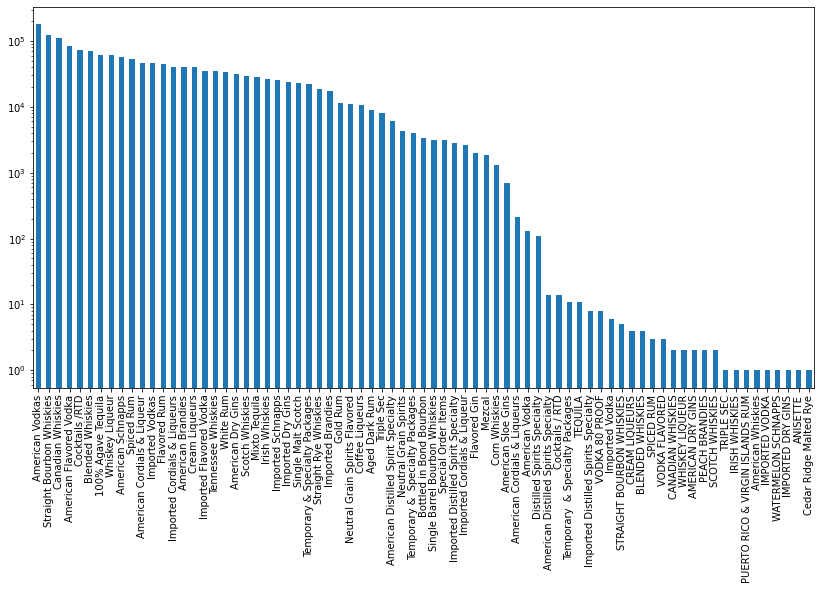

In [11]:
plt.figure(figsize = (14,7))
hv['Category Name'].value_counts().plot.bar()
plt.yscale("log")

- American Vodkas are the most popular transaction in Hy-Vee stores (Iowa)

<Figure size 1440x720 with 0 Axes>

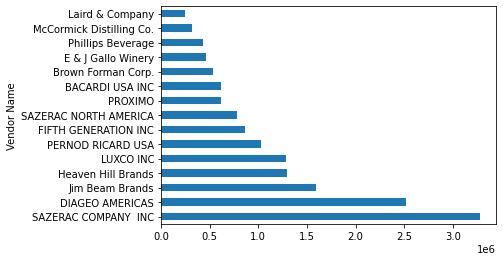

<Figure size 1440x720 with 0 Axes>

In [12]:
hv.groupby("Vendor Name")["Bottles Sold"].sum().sort_values(ascending = False).head(15).plot(kind ="barh")
plt.figure(figsize = (20,10))

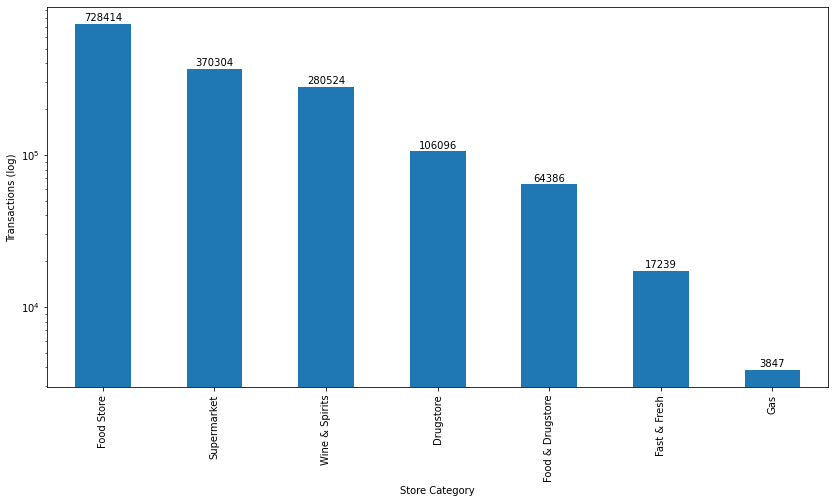

In [13]:
plt.figure(figsize = (14,7))
ax = hv['Store Category'].value_counts().plot.bar()
plt.yscale("log")
plt.xlabel('Store Category')
plt.ylabel('Transactions (log)')


for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

<AxesSubplot:xlabel='Store Category', ylabel='Bottles Sold'>

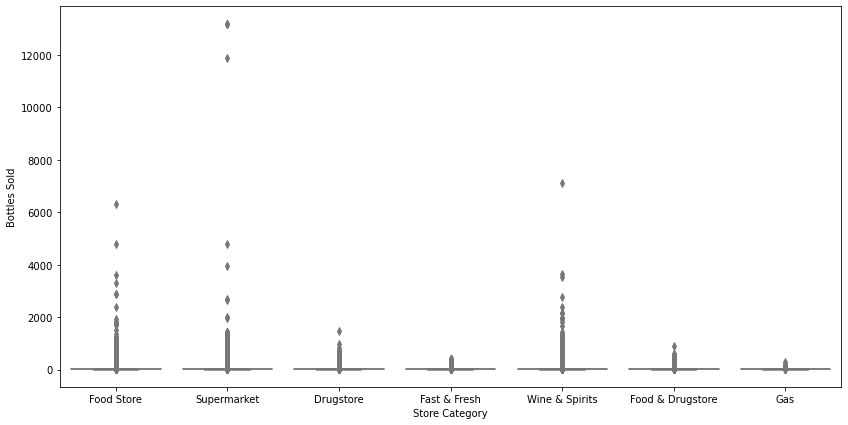

In [14]:
plt.figure(figsize = (14,7))
sns.boxplot(x="Store Category", y="Bottles Sold", data=hv, linewidth=1.5, color='lightsteelblue')

- Most people in Iowa who are customers of the Hy-Vee chain, purchase their liquor most often at food stores and least at Gas stations

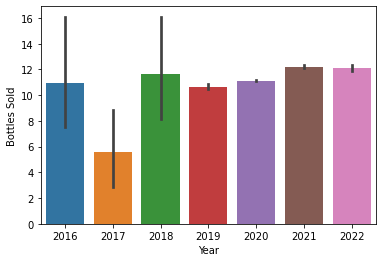

In [15]:
ax = sns.barplot(x = "Year", y = "Bottles Sold", data = hv)
plt.show()

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()


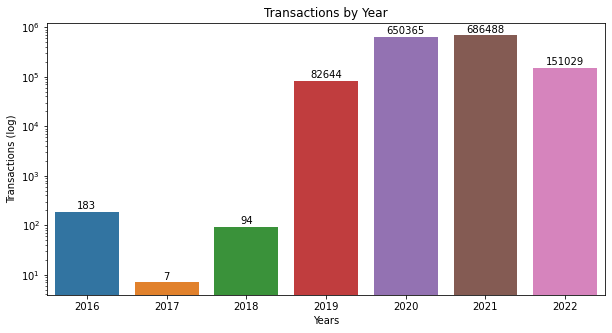

In [16]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(hv['Year'])
plt.yscale("log")
plt.xlabel('Years')
plt.ylabel('Transactions (log)')
plt.title('Transactions by Year')

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

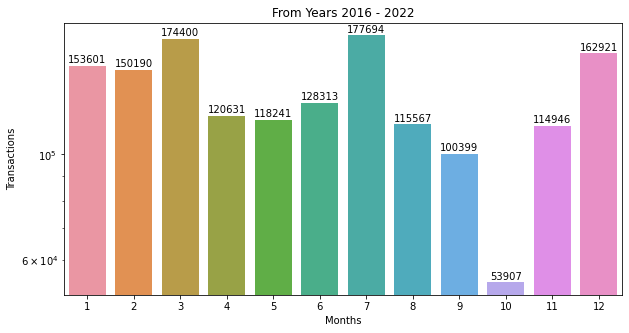

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(hv['Month'])
plt.yscale("log")
plt.xlabel('Months')
plt.ylabel('Transactions')
plt.title("From Years 2016 - 2022")

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [18]:
hv["Store Category"].unique()

array(['Food Store', 'Supermarket', 'Drugstore', 'Fast & Fresh',
       'Wine & Spirits', 'Food & Drugstore', 'Gas'], dtype=object)

In [19]:
supermarket = hv[hv["Store Category"] == "Supermarket"]
foodstore = hv[hv["Store Category"] == "Food Store"]
gas = hv[hv["Store Category"] == "Gas"]
drugstore = hv[hv["Store Category"] == "Drugstore"]
fast_fresh = hv[hv["Store Category"] == "Fast & Fresh"]
wine_spirit = hv[hv["Store Category"] == "Wine & Spirits"]
food_drug = hv[hv["Store Category"] == "Food & Drugstore"]

In [20]:
category_name_top10 = hv['Category Name'].value_counts().head(10)

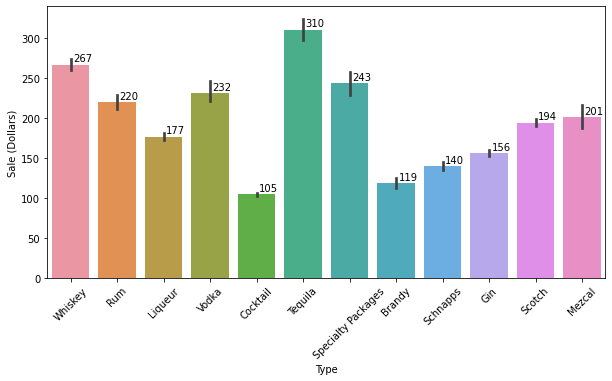

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = supermarket)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [22]:
hv.loc[hv["Category Name"].str.contains('Special')].head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
32,INV-24117300032,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1701100,Temporary & Specialty Packages,420,MOET HENNESSY USA,100873,Ardbeg 10YR w/Ardbone Tin,6,750.0,26.49,39.74,6,238.44,4.50,1.18,Drugstore,2019,12,Specialty Packages
45,INV-24116900112,2019-12-23,2670,Hy-Vee Food Store / Coralville,2004 8th St,Coralville,52241,POINT (-91.591868 41.682337000000004),52,JOHNSON,1092100,Imported Distilled Spirit Specialty,353,"John Ernest Distillery, Inc.",65750,Maestro Agavero Gold,12,1000.0,7.00,10.50,48,504.00,48.00,12.68,Food Store,2019,12,Liqueur
114,INV-24099700020,2019-12-23,2665,Hy-Vee / Waukee,1005 E Hickman Rd,Waukee,50263,POINT (-93.854477 41.615059),25,DALLAS,1701100,Temporary & Specialty Packages,259,Heaven Hill Brands,2229,Christian Bros Holiday Nog,12,750.0,4.47,6.71,12,80.52,9.00,2.37,Supermarket,2019,12,Specialty Packages
151,INV-24113000061,2019-12-23,2509,Hy-Vee / Drugtown #1 / Cedar Rapids,1520 6th St SW,Cedar Rapids,52404,POINT (-91.67706 41.962419),57,LINN,1701100,Temporary & Specialty Packages,205,E & J Gallo Winery,39492,New Amsterdam Pink Whitney,12,750.0,7.50,11.25,3,33.75,2.25,0.59,Supermarket,2019,12,Specialty Packages
172,INV-24110700220,2019-12-23,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,1092100,Imported Distilled Spirit Specialty,421,SAZERAC COMPANY INC,77487,Tortilla Gold DSS,12,1000.0,4.85,7.28,660,4804.80,660.00,174.35,Supermarket,2019,12,Liqueur


In [23]:
sm_sales_by_type = pd.DataFrame(supermarket.groupby(["Type"])["Sale (Dollars)"].sum()).reset_index()
sm_sales_by_type

,Type,Sale (Dollars)
0,Brandy,1462054.13
1,Cocktail,1888923.64
2,Gin,2296807.46
3,Liqueur,9933409.62
4,Mezcal,121571.71
5,Rum,7904324.34
6,Schnapps,2655139.83
7,Scotch,2386083.45
8,Specialty Packages,1718117.12
9,Tequila,6957524.82


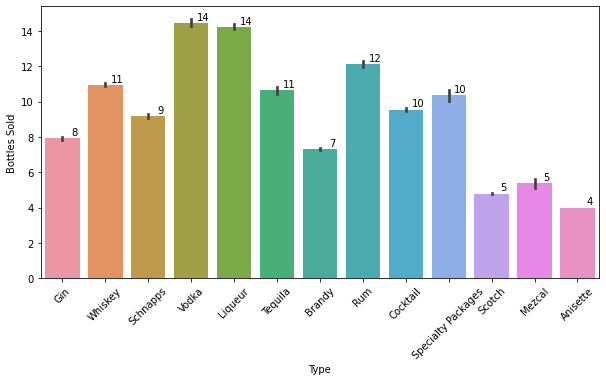

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Bottles Sold", data = hv)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

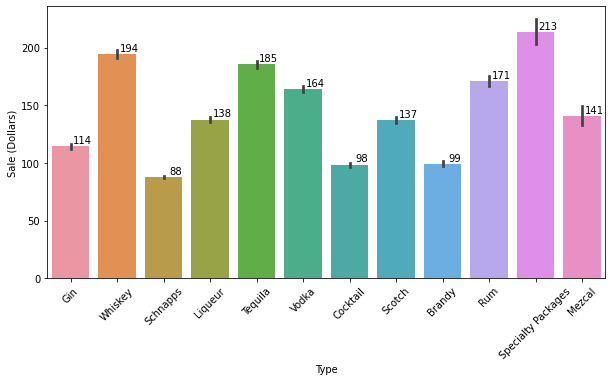

In [25]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = foodstore)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

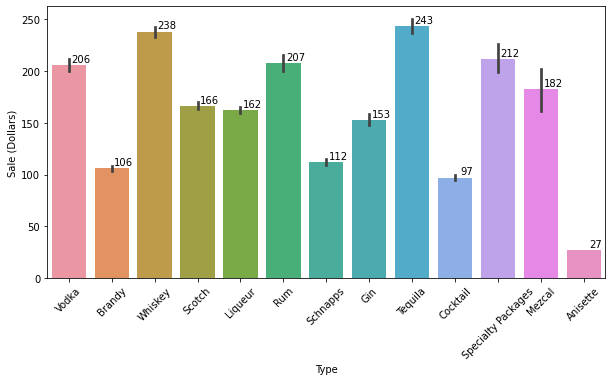

In [26]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = wine_spirit)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

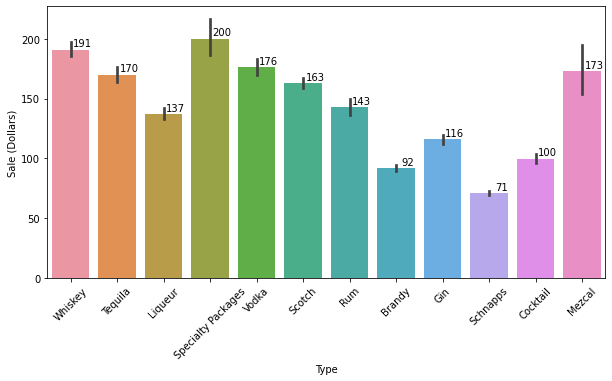

In [27]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = drugstore)
plt.xticks(rotation=45)

    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(12, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

## Sale By Time

### Month

In [28]:
month_sales = pd.DataFrame(hv.groupby(["Month"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
month_sales

,Month,Sale (Dollars)
0,3,30483526.01
1,7,29753063.44
2,12,28782982.93
3,2,27253304.83
4,1,24083549.54
5,6,22093623.90
6,4,20772737.78
7,11,20747336.11
8,8,20483894.91
9,5,19549554.67


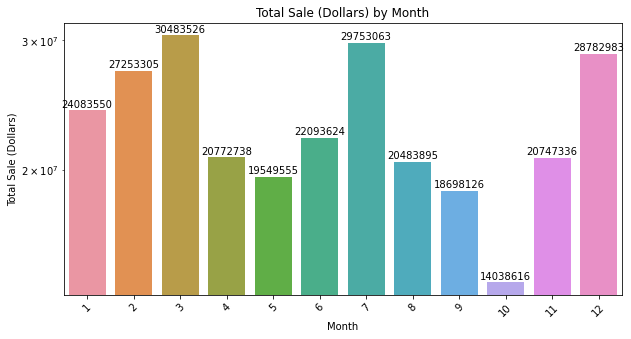

In [29]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Month", y = "Sale (Dollars)", data = month_sales)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Month')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [30]:
hv[hv["Month"] == 9]["Sale (Dollars)"].sum()

18698126.470000003

### Sale By Year

In [31]:
yearly_sales = pd.DataFrame(hv.groupby(["Year"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
yearly_sales

,Year,Sale (Dollars)
0,2021,1.287281e+08
1,2020,1.069798e+08
2,2022,2.836024e+07
3,2019,1.263035e+07
4,2016,3.106487e+04
5,2018,1.023461e+04
6,2017,5.262300e+02


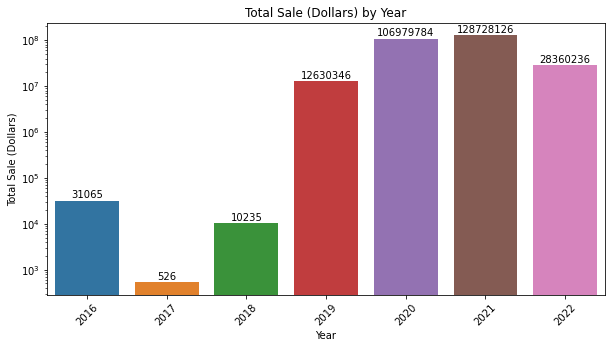

In [32]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Year", y = "Sale (Dollars)", data = yearly_sales)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Year')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

## Sale by store category

In [130]:
storecat_2021 = hv[hv["Year"] == 2021].head()
store_sales_2021 = pd.DataFrame(storecat_2021.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales_2021.head()

,Store Category,Sale (Dollars)
0,Food Store,279.57
1,Wine & Spirits,35.97
2,Supermarket,21.00


In [ ]:
store_sales = pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales

In [ ]:
store_sales = pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales

In [33]:
store_sales = pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
store_sales

,Store Category,Sale (Dollars)
0,Food Store,1.152827e+08
1,Supermarket,8.031154e+07
2,Wine & Spirits,5.391428e+07
3,Drugstore,1.661517e+07
4,Food & Drugstore,9.061924e+06
5,Fast & Fresh,1.275901e+06
6,Gas,2.787540e+05


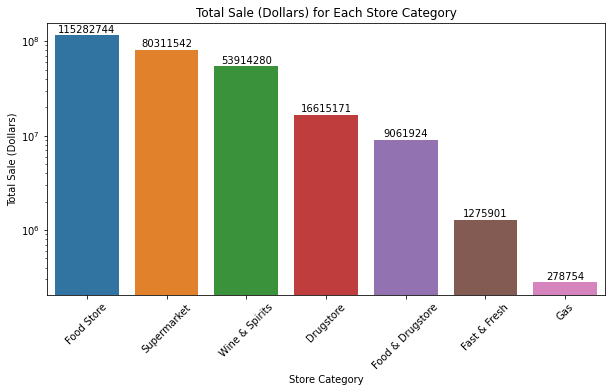

In [34]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Store Category", y = "Sale (Dollars)", data = store_sales)
plt.xticks(rotation=45)
plt.yscale("log")
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) for Each Store Category')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [110]:
len(hv[hv["Year"] == 2016]["Store Number"].unique())

17

In [111]:
#hv[hv["Year"] == 2017]["Store Category"].value_counts()
len(hv[hv["Year"] == 2017]["Store Number"].unique())

1

In [112]:
#hv[hv["Year"] == 2018]["Store Category"].value_counts()
len(hv[hv["Year"] == 2018]["Store Number"].unique())

8

In [113]:
len(hv[hv["Year"] == 2019]["Store Number"].unique())

126

In [114]:
len(hv[hv["Year"] == 2020]["Store Number"].unique())

156

In [115]:
len(hv[hv["Year"] == 2021]["Store Number"].unique())

161

In [116]:
len(hv[hv["Year"] == 2022]["Store Number"].unique())

158

In [35]:
hv["Store Category"].value_counts()

Food Store          728414
Supermarket         370304
Wine & Spirits      280524
Drugstore           106096
Food & Drugstore     64386
Fast & Fresh         17239
Gas                   3847
Name: Store Category, dtype: int64

In [125]:
len(hv[hv["Store Category"] == "Food Store"]["Store Number"].unique())

58

In [126]:
len(hv[hv["Store Category"] == "Supermarket"]["Store Number"].unique())

48

In [127]:
len(hv[hv["Store Category"] == "Wine & Spirits"]["Store Number"].unique())

21

In [123]:
115292744 / 728414 

158.2791434541346

## Sale by county

In [36]:
county_sales = pd.DataFrame(hv.groupby(["County"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()[:10]
county_sales

,County,Sale (Dollars)
0,POLK,80674141.13
1,JOHNSON,23711867.16
2,LINN,22864341.82
3,SCOTT,17483864.16
4,BLACK HAWK,8917544.38
5,STORY,8185190.52
6,WOODBURY,8176029.77
7,POTTAWATTA,7382037.11
8,CERRO GORD,6920080.30
9,DALLAS,6640423.78


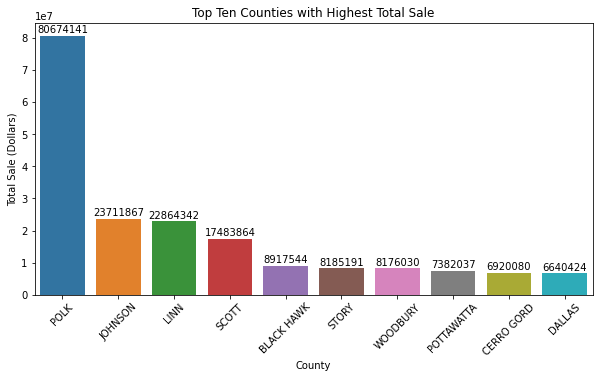

In [37]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "County", y = "Sale (Dollars)", data = county_sales)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Top Ten Counties with Highest Total Sale')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [38]:
county_bottles_sold = pd.DataFrame(hv.groupby(["County"])["Bottles Sold"].sum().sort_values(ascending=False)).reset_index()[:10]
county_bottles_sold

,County,Bottles Sold
0,POLK,5266541
1,LINN,1713475
2,JOHNSON,1468671
3,SCOTT,1144220
4,BLACK HAWK,593959
5,WOODBURY,540838
6,STORY,518070
7,CERRO GORD,495054
8,POTTAWATTA,479111
9,DALLAS,427962


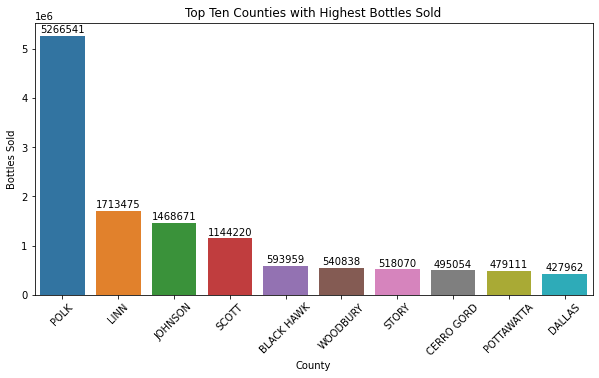

In [39]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "County", y = "Bottles Sold", data = county_bottles_sold)
plt.xticks(rotation=45)
plt.ylabel('Bottles Sold')
plt.title('Top Ten Counties with Highest Bottles Sold')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

Order of the total sale and bottles sold is different
- look into what is the top product sold then compare price for each item

In [40]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey


In [41]:
hv[hv["County"]=="LINN"]["Item Description"].value_counts()[:5]

Titos Handmade Vodka         2184
Fireball Cinnamon Whiskey    2075
Black Velvet                 1990
Hawkeye Vodka                1913
Crown Royal                  1279
Name: Item Description, dtype: int64

In [42]:
hv[hv["County"]=="JOHNSON"]["Item Description"].value_counts()[:5]

Titos Handmade Vodka         1033
Black Velvet                  949
Fireball Cinnamon Whiskey     902
Hawkeye Vodka                 852
Crown Royal                   825
Name: Item Description, dtype: int64

### Price, Profit and transaction for Titos

#### uinque stores per county

In [43]:
len(hv[hv["County"]=="JOHNSON"]["Store Number"].unique())

7

In [44]:
len(hv[hv["County"]=="LINN"]["Store Number"].unique())

13

#### Avg sale price

In [45]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["Sale (Dollars)"].mean()

1566.835876089067

In [46]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["Sale (Dollars)"].mean()

664.1011309523849

#### Avg retail price

In [47]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].mean()

16.86816069699898

In [48]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].mean()

16.28330586080581

#### Avg. Bottle Cost

In [49]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean()

11.24398838334948

In [50]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean()

10.854299450549279

#### Avg. Profit

In [51]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].mean() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean()

5.624172313649501

In [52]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].mean() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean()

5.429006410256532

#### Markup Percentage

In [53]:
((hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].mean() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean()) / (hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean())) * 100

50.019371435655216

In [54]:
((hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Retail"].mean() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean()) / (hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Titos Handmade Vodka")]["State Bottle Cost"].mean())) * 100

50.01710552569838

### Price for Fireball

#### Transactions per county

In [55]:
len((hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey"))

1570810

In [56]:
len((hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey"))

1570810

In [57]:
len((hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey"))

1570810

#### Avg Sale Price

In [58]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["Sale (Dollars)"].mean()

362.28863636363445

In [59]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["Sale (Dollars)"].mean()

210.93191807228885

#### Avg retail price

In [60]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].mean()

10.604578713969053

In [61]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].mean()

7.638019277108562

#### Avg. Bottle Cost

In [62]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean()

7.069002217294876

In [63]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean()

5.091426506024008

#### Avg. Profit

In [64]:
hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].mean() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean()

3.535576496674177

In [65]:
hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].mean() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean()

2.546592771084554

#### Markup Percentage

In [66]:
((hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].mean() - hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean()) / (hv[(hv["County"]=="JOHNSON") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean())) * 100

50.01521272725178

In [67]:
((hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Retail"].mean() - hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean()) / (hv[(hv["County"]=="LINN") & (hv["Item Description"] == "Fireball Cinnamon Whiskey")]["State Bottle Cost"].mean())) * 100

50.01727449215871

TypeError: 'AxesSubplot' object is not subscriptable

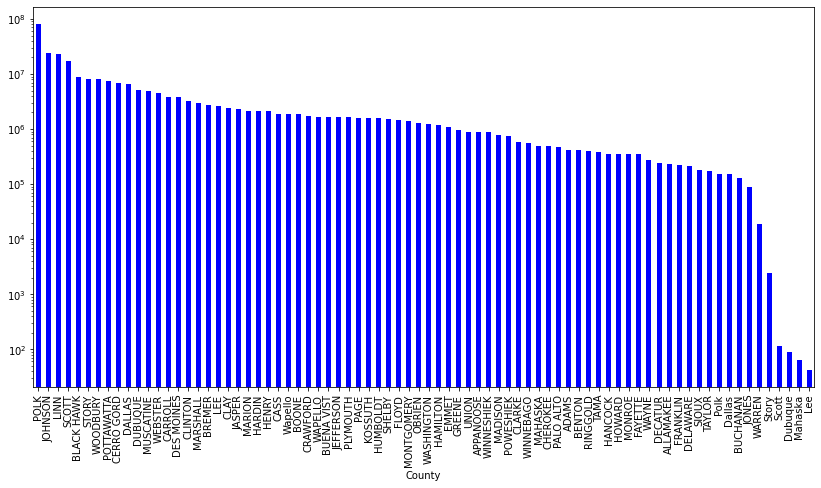

In [68]:
plt.figure(figsize = (14,7))
plt.yscale("log")
hv.groupby("County")["Sale (Dollars)"].sum().sort_values(ascending=False).plot.bar(color = 'b')[:10]

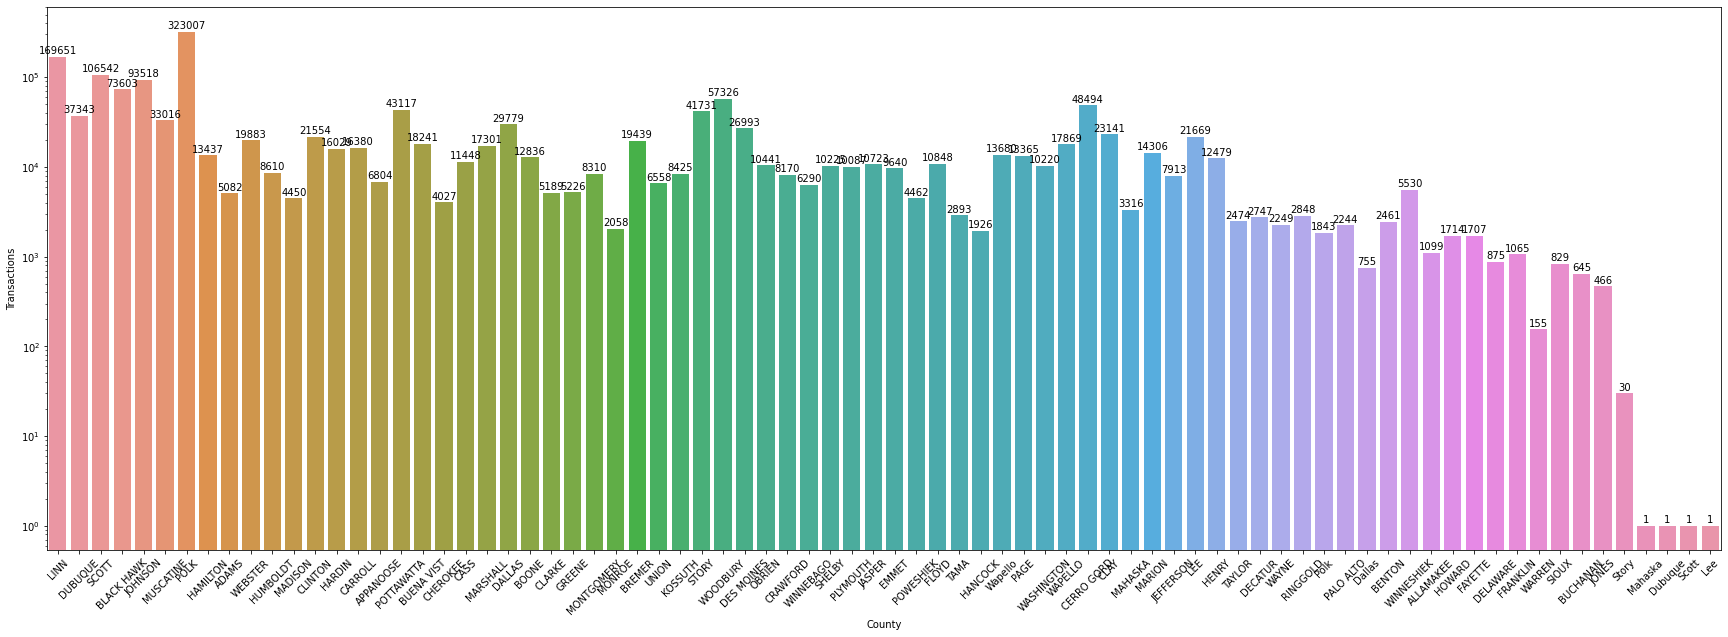

In [69]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(hv['County'])
plt.xticks(rotation=45)
plt.yscale("log")
plt.xlabel('County')
plt.ylabel('Transactions')

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [70]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey


In [71]:
liquor_type_sales = pd.DataFrame(hv.groupby(["Type"])["Sale (Dollars)"].sum().sort_values(ascending=False)).reset_index()
liquor_type_sales

,Type,Sale (Dollars)
0,Whiskey,85056170.59
1,Vodka,64286268.07
2,Liqueur,35607474.74
3,Rum,27988369.12
4,Tequila,20076033.46
5,Schnapps,8593684.79
6,Scotch,8152081.31
7,Gin,7713820.40
8,Cocktail,7214471.15
9,Brandy,5942437.01


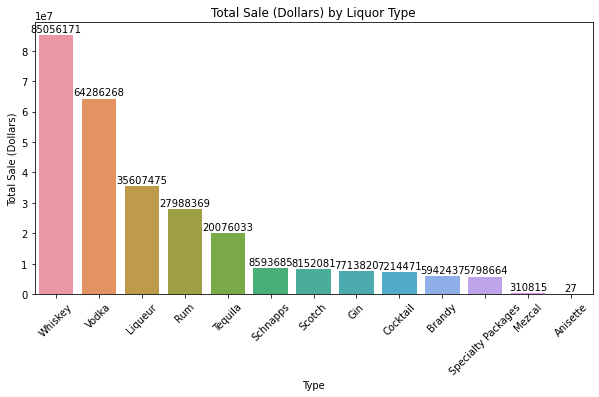

In [72]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Sale (Dollars)", data = liquor_type_sales)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Sale (Dollars) by Liquor Type')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [73]:
liquor_type_bottles = pd.DataFrame(hv.groupby(["Type"])["Bottles Sold"].sum().sort_values(ascending=False)).reset_index()
liquor_type_bottles

,Type,Bottles Sold
0,Vodka,4981893
1,Whiskey,4319065
2,Liqueur,3376153
3,Rum,1840955
4,Tequila,959471
5,Schnapps,764948
6,Cocktail,688900
7,Gin,464484
8,Brandy,422769
9,Specialty Packages,274362


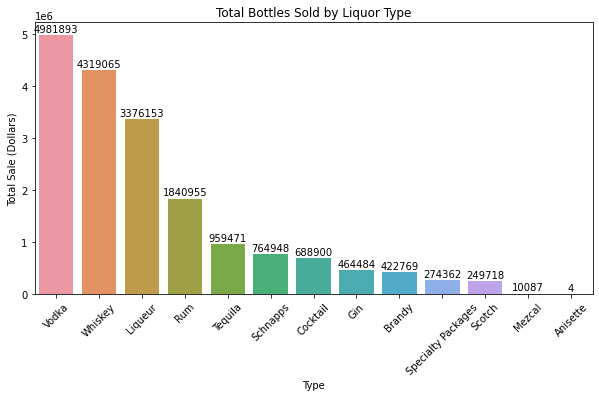

In [74]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = "Type", y = "Bottles Sold", data = liquor_type_bottles)
plt.xticks(rotation=45)
plt.ylabel('Total Sale (Dollars)')
plt.title('Total Bottles Sold by Liquor Type')
    
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [75]:
hv['Latitude'] = hv.apply(lambda row: row['Store Location'].split(' ')[1].replace('(', ''), axis=1)
hv['Longitude'] = hv.apply(lambda row: row['Store Location'].split(' ')[2].replace(')',''), axis=1)
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type,Latitude,Longitude
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin,-91.697941,41.97447
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey,-90.666497,42.49721900000001
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey,-90.608201,41.560663
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey,-92.327917,42.459938
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey,-90.548919,41.55678100000001


In [76]:
hv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570810 entries, 0 to 1570809
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Invoice/Item Number    1570810 non-null  object        
 1   Date                   1570810 non-null  datetime64[ns]
 2   Store Number           1570810 non-null  int64         
 3   Store Name             1570810 non-null  object        
 4   Address                1570810 non-null  object        
 5   City                   1570810 non-null  object        
 6   Zip Code               1570810 non-null  int64         
 7   Store Location         1570810 non-null  object        
 8   County Number          1570810 non-null  int64         
 9   County                 1570810 non-null  object        
 10  Category               1570810 non-null  int64         
 11  Category Name          1570810 non-null  object        
 12  Vendor Number          15708

In [77]:
hv["Latitude"] = hv.Latitude.astype(float)
hv["Longitude"] = hv.Longitude.astype(float)

In [78]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type,Latitude,Longitude
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin,-91.697941,41.974470
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey,-90.666497,42.497219
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey,-90.608201,41.560663
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey,-92.327917,42.459938
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey,-90.548919,41.556781


In [79]:
# m = ipyleaflet.Map(center=(23,72), zoom=7, basemap = basemaps.Esri.WorldStreetMap)

# markers = []
# for City, StoreLocation in hv[["City", "Store Location"]].values:
#     markers.append(ipyleaflet.Marker(location=(StoreLocation), draggable=False, title=City, alt=City))


# marker_cluster = MarkerCluster(markers=markers)
# m.add_layer(marker_cluster)

# m.layout.height="550px"

# m

In [80]:
# from ipyleaflet import Marker

# m = Map(center=(-91.697941,41.974470), zoom=4, basemap = basemaps.Esri.WorldStreetMap)

# for name, lon, lat in hv[["Store Name", "Longitude", "Latitude"]].values:
#     marker = Marker(location=(lat, lon), draggable=False, title=name, alt=name)
#     m.add_layer(marker)

# # m.layout.height="550px"

# m

In [81]:
# m = folium.Map(location = [-91.697941, 41.974470], tiles ='OpenStreetMap', zoom_start=11)

# for i, row in hv.iterrows():
#     lat = hv.at[i, 'Latitude']
#     lng = hv.at[i, 'Longitude']
    
# #     popup = 'Station : ' + str(df.at[i, 'Stations']) + '<br>' + \                     
# #               '<br>' +'Address: ' + df.at[i, 'Address']
    
#     folium.Marker(location = [lat, lng], icon = folium.Icon(color='blue')).add_to(m)
    
# m.save('Hy-Vee_Iowa_Locations.html')
# m

In [82]:
# import folium
# from IPython.display import display

# mymap= folium.Map(location=[-91.697941, 41.974470], zoom_start=8, )

# hm_wide = HeatMap(
#     list(zip(hv.Latitude.values, hv.Longitude.values)),
#     min_opacity=0.3,
#     radius=10, 
#     blur=9, 
#     max_zoom=1,
# )
# mymap.add_child(hm_wide)

In [83]:
# sd = hv[['Sale (Dollars)']]
# sd.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
# plt.xlabel('Year', fontsize=20);

In [84]:
# yearly_sale = hv[["Date", "Sale (Dollars)"]]

In [85]:
# yearly_sale.head()

In [86]:
# yearly_sale2 = yearly_sale.set_index('Date').asfreq('D')
# yearly_sale_arima = seasonal_decompose(yearly_sale2, model ='multiplicative')
# yearly_sale_arima.plot()

In [87]:
# import statsmodels as sm
# import statsmodels.api as sm

# sm.tsa.seasonal_decompose(yearly_sale.asfreq('MS'), model = 'additive')

In [88]:
# X_train = hv[hv["Date"] < "2022-12-31"]
# X_valid = hv[hv["Date"] >= "2017-01-01"]

In [89]:
# #ARIMA

# au = X_train[X_train["Store Category"] == "Supermarket"]
# au2 = au[["Date", "Sale (Dollars)"]]

# au_v = X_valid[X_valid["Store Category"] == "Supermarket"]
# au_v2 = au_v[["Date", "Sale (Dollars)"]]

# au2.set_index("Date", inplace = True)
# au_v2.set_index("Date", inplace = True)

# index_7_years = pd.date_range(au2.index[-1], freq="AS", periods = 7)
# index_7_years

In [90]:
# model_arima = ARIMA(au2, order = (2,0,0))
# model_arima_fit = model_arima.fit(disp=-1)

# fcast1 = model_arima_fit.forecast(7)[0]

# fcast1 = pd.Series(fcast1, index= index_7_years)
# fcast1 = fcast1.rename("Arima")

# fig,ax = plt.subplots(figsize=(15,5))
# chart = sns.lineplot(x="Date", y="Sale (Dollars)", data = supermarket_arima)
# chart.set_title("AU")
# fcast1.plot(ax=ax, color="red", marker = "o", legend=True)
# au_v2.plot(ax=ax, color="red", marker = "o", legend=True)

In [91]:
sales_by_year =  pd.DataFrame(hv.groupby("Year")["Sale (Dollars)"].sum()).reset_index()
sales_by_year.head()

,Year,Sale (Dollars)
0,2016,3.106487e+04
1,2017,5.262300e+02
2,2018,1.023461e+04
3,2019,1.263035e+07
4,2020,1.069798e+08


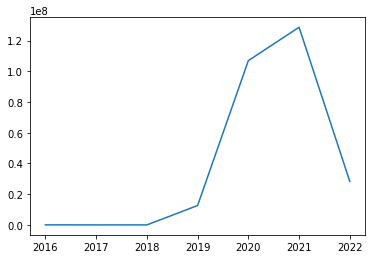

In [92]:
plt.plot(sales_by_year["Year"],sales_by_year["Sale (Dollars)"])

In [93]:
store_sales_by_year =  pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum()).reset_index()
store_sales_by_year.head()

,Store Category,Sale (Dollars)
0,Drugstore,1.661517e+07
1,Fast & Fresh,1.275901e+06
2,Food & Drugstore,9.061924e+06
3,Food Store,1.152827e+08
4,Gas,2.787540e+05


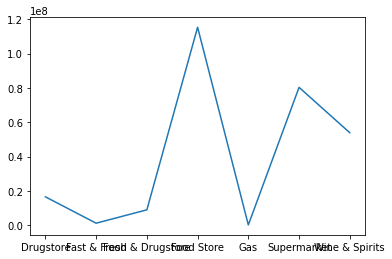

In [94]:
plt.plot(store_sales_by_year["Store Category"],store_sales_by_year["Sale (Dollars)"])

In [95]:
hv.head(3)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type,Latitude,Longitude
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.0,2.37,Food Store,2019,12,Gin,-91.697941,41.974470
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.0,2.37,Supermarket,2019,12,Whiskey,-90.666497,42.497219
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.5,1.18,Drugstore,2019,12,Whiskey,-90.608201,41.560663


In [96]:
sm_sale_year = hv[hv["Store Category"] == "Supermarket"][["Year","Sale (Dollars)"]]
sm_sale_year.head()

,Year,Sale (Dollars)
1,2019,280.32
16,2019,169.56
19,2019,189.00
21,2019,94.56
28,2019,25.20


In [97]:
sm_sale_year.rename(columns = {'Sale (Dollars)':'Sale'}, inplace = True)
sm_sale_year.head()

,Year,Sale
1,2019,280.32
16,2019,169.56
19,2019,189.00
21,2019,94.56
28,2019,25.20


In [98]:
# import datetime
# hv["Month_Year"] = pd.to_datetime(hv[["Month", "Year"]])

In [99]:
store_sales_by_year =  pd.DataFrame(hv.groupby(["Store Category"])["Sale (Dollars)"].sum()).reset_index()
store_sales_by_year.head()

,Store Category,Sale (Dollars)
0,Drugstore,1.661517e+07
1,Fast & Fresh,1.275901e+06
2,Food & Drugstore,9.061924e+06
3,Food Store,1.152827e+08
4,Gas,2.787540e+05


- MBA
    - group by store and day
    - each store number is person
    - each day is a transaction
    - so 7 transactions max in a week per store number

In [100]:
hv.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type,Latitude,Longitude
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin,-91.697941,41.974470
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey,-90.666497,42.497219
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey,-90.608201,41.560663
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey,-92.327917,42.459938
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey,-90.548919,41.556781


In [101]:
hv.groupby("Store Number").head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Store Category,Year,Month,Type,Latitude,Longitude
0,INV-24107200133,2019-12-23,2508,Hy-Vee Food Store #1 / Cedar Rapids,"1843 Johnson Avenue, N.W.",Cedar Rapids,52405,POINT (-91.697941 41.97447),57,LINN,1041100,American Dry Gins,370,PERNOD RICARD USA,32236,Seagrams Extra Dry Gin,12,750.0,6.49,9.74,12,116.88,9.00,2.37,Food Store,2019,12,Gin,-91.697941,41.974470
1,INV-24090200052,2019-12-20,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001,POINT (-90.666497 42.49721900000001),31,DUBUQUE,1011400,Tennessee Whiskies,85,Brown Forman Corp.,26826,Jack Daniels Old #7 Black Label,12,750.0,15.57,23.36,12,280.32,9.00,2.37,Supermarket,2019,12,Whiskey,-90.666497,42.497219
2,INV-24117700068,2019-12-23,2567,Hy-Vee Drugstore / Davenport,2200 West Kimberly,Davenport,52806,POINT (-90.608201 41.560663),82,SCOTT,1011200,Straight Bourbon Whiskies,65,Jim Beam Brands,19066,Jim Beam,12,750.0,10.50,15.75,6,94.50,4.50,1.18,Drugstore,2019,12,Whiskey,-90.608201,41.560663
3,INV-24105000057,2019-12-23,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,1011100,Blended Whiskies,65,Jim Beam Brands,24456,Kessler Blend Whiskey,12,750.0,5.51,8.27,3,24.81,2.25,0.59,Food Store,2019,12,Whiskey,-92.327917,42.459938
4,INV-24117300020,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1011100,Blended Whiskies,65,Jim Beam Brands,27680,Jim Beam Kentucky Fire Mini,12,50.0,5.40,8.10,12,97.20,0.60,0.15,Drugstore,2019,12,Whiskey,-90.548919,41.556781
5,INV-24116900184,2019-12-23,2670,Hy-Vee Food Store / Coralville,2004 8th St,Coralville,52241,POINT (-91.591868 41.682337000000004),52,JOHNSON,1012100,Canadian Whiskies,421,SAZERAC COMPANY INC,11347,Seagrams VO Canadian Whiskey,12,1000.0,6.63,9.95,12,119.40,12.00,3.17,Food Store,2019,12,Whiskey,-91.591868,41.682337
6,INV-24092600158,2019-12-20,2573,Hy-Vee Food Store / Muscatine,2400 2nd Ave,Muscatine,52761,POINT (-91.035138 41.451349),70,MUSCATINE,1082200,Imported Schnapps,421,SAZERAC COMPANY INC,65066,Goldschlager Cinnamon Schnapps,12,750.0,13.00,19.50,3,58.50,2.25,0.59,Food Store,2019,12,Schnapps,-91.035138,41.451349
7,INV-24113800013,2019-12-23,2691,Hy-Vee Fast & Fresh - Des Moines,5801 Hickman Road,Urbandale,50322,POINT (-93.698172 41.614888),77,POLK,1031200,American Flavored Vodka,380,Phillips Beverage,41691,UV Blue Raspberry Mini,12,50.0,4.40,6.60,1,6.60,0.05,0.01,Fast & Fresh,2019,12,Vodka,-93.698172,41.614888
8,INV-24086100102,2019-12-20,2602,Hy-Vee Food Store / Webster City,823 2nd St,Webster City,50595,POINT (-93.825486 42.469466),40,HAMILTON,1081200,Cream Liqueurs,434,LUXCO INC,68846,St Brendans Irish Cream,12,750.0,7.69,11.54,6,69.24,4.50,1.18,Food Store,2019,12,Liqueur,-93.825486,42.469466
9,INV-24117300269,2019-12-23,2614,Hy-Vee #3 Food & Drugstore / Davenport,1823 E Kimberly Rd,Davenport,52807,POINT (-90.548919 41.55678100000001),82,SCOTT,1022100,Mixto Tequila,395,PROXIMO,89199,Jose Cuervo Especial Reposado Square,12,375.0,5.50,8.25,6,49.50,2.25,0.59,Drugstore,2019,12,Tequila,-90.548919,41.556781


# MBA

In our current data, a single row consists of the order of a single liquor product item. In order for the technique to be applicable, we aggregate the data according to the customers (in this case the store number), dates with a weekly or a monthly frequency.

In [ ]:
mba_df2 = hv.groupby(["Store Number","Date"])["Item Description"].apply(list).reset_index()
mba_df2 = pd.DataFrame(mba_df2)
mba_df2.head(10)

In [ ]:
mba_df2_csv = mba_df2.to_csv('mba_df2.csv', index = True)

In [ ]:
mba_df2.shape

In [ ]:
transactions = []
for i in range(0, 18110):
  transactions.extend(mba_df2["Item Description"])

In [ ]:
transactions[:2]

In [ ]:
from apyori import apriori
rules = apriori(transactions =transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2, max_length = 2)

In [ ]:
results = list(rules)

In [ ]:
results[:-1]

In [ ]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [ ]:
resultsinDataFrame

In [ ]:
mba_df = hv.groupby(["Store Number","Date","Month","Year"]).apply(lambda d: d["Item Description"].tolist())
mba_df = pd.DataFrame(mba_df.tolist(), index=mba_df.index)
mba_df.head(10)

In [ ]:
mba_df.reset_index(inplace = True)
mba_df.head()

In [ ]:
mba_df_csv = mba_df.to_csv('mba_df.csv', index = True)

In [ ]:
mba_df2 = hv.groupby(["Store Number","Date","Month","Year", "County Number", "Store Category"]).apply(lambda d: d["Item Description"].tolist())
mba_df2 = pd.DataFrame(mba_df2.tolist(), index=mba_df2.index)
mba_df2.head(10)

In [ ]:
mba_df2.reset_index(inplace = True)
mba_df2.head()

In [ ]:
mba_df_2_csv = mba_df2.to_csv('mba_df2.csv', index = True)

In [ ]:
# mba_df.shape

In [ ]:
# num_rows = 18110
# num_cols = 834
# transactions = mba_df.iloc[:num_rows, 4:num_cols].astype(str).values.tolist()

In [ ]:
# transactions[:2]

In [ ]:
# results = list(rules)

In [ ]:
# results[:2]

In [ ]:
mba_df["Store Number"] = mba_df["Store Number"].astype(int)
mba_df["Date"] =  pd.to_datetime(hv["Date"], format="%m/%d/%Y")
mba_df["Month"] = mba_df["Month"].astype(int)
mba_df["Year"] = mba_df["Year"].astype(int)